# LagLlama Zero Shot for Time Series Forecasting

In this notebook, we’ll learn how to use **LagLlama** to tackle a forecasting task. Along the way, you’ll explore the details of the model and pick up key ideas that you can apply to your own projects with your own data. By the end, you’ll have a stronger foundation to use **LagLlama** for solving your own forecasting problems.

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **GluonTS** for time series modeling  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
# -----------------------------------------------------------
# Imports: Required Libraries for Forecasting Experiments
# -----------------------------------------------------------

# --- Data Manipulation and Numerical Computation ---
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations on arrays

# --- Data Loading and Preprocessing ---
from datasets import load_dataset  # Hugging Face datasets library for standardized data loading
from genai4t.data.processing import dataset_to_pandas  # Custom utility to convert Hugging Face datasets to pandas DataFrames

# --- Configuration Management and Utilities ---
from omegaconf import OmegaConf  # Hydra-compatible tool for managing experiment configurations
from genai4t.utils import get_torch_device, set_random_state  # Helpers for device selection and reproducibility

# --- Forecasting Model Utilities ---
from genai4t.model.utils import fit_model  # Function to train GluonTS-based models
from genai4t.forecasting.util import create_predictions_dataframe  # Converts model outputs into a pandas DataFrame format
from gluonts.model.forecast import SampleForecast  # GluonTS forecast object used for evaluating model predictions
from gluonts.evaluation.backtest import _to_dataframe # Transform datasets to dataframs
# --- Visualization ---
from matplotlib import pyplot as plt  # For plotting time series and forecasts
from genai4t.plot_style import plot_style # For plotting style
import seaborn as sns 

# --- Miscellaneous ---
from itertools import islice  # Useful for slicing iterables (e.g., previewing data)
from typing import List  # Type hinting support

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        # Whether to use GPU acceleration if available
        # Set to True to enable GPU usage for faster training
        # Will fall back to CPU if GPU is not available
        "use_cuda": True,
        
        # Set random seed for reproducibility
        # Using a fixed seed ensures you get the same results each time you run the code
        # Change this value to get different but still reproducible results
        "random_state": 2024
    }

DATA_CONFIG = {
        # Name of the dataset to load from HuggingFace hub
        # This dataset contains exchange rate data
        "name": "gatam4t/genai4t_exchange_rate",

        # Date to split data into training and test sets
        # Data before this date will be used for training
        # Data after this date will be used for testing
        "split_date": "2016-01-01",

        # Number of future time steps to predict
        "prediction_length": 1,

        # Number of past time steps to use for making predictions
        # Model will look at 30 days of history
        "context_length": 30,

        # Number of sample paths to generate for probabilistic forecasting
        # Higher values give better uncertainty estimates but take longer
        "num_samples": 20,

        # Frequency of the time series data
        # 'B' means business days (Monday-Friday)
        "freq": 'B',

        # Number of time series to process simultaneously during training
        # Larger batch sizes can speed up training but use more memory
        "batch_size": 32,

        # Number of batches in an epoch
        "num_batches_per_epoch": 50,
    }

In [3]:
# --------------------------------------------
# Load Configuration and Set Up Environment
# --------------------------------------------

# Select computation device: GPU (if available) or CPU
device = get_torch_device()

# Set random seed for reproducibility
# Ensures consistent results across multiple runs
set_random_state(ENV_CONFIG["random_state"])

Seed set to 2024


## Load Data

For this experiment, we’ll use the **Exchange Rate** dataset—a multivariate time series dataset commonly used in academic benchmarks for forecasting models. It consists of daily exchange rates for eight currencies (Australia, United Kingdom, Canada, Switzerland, China, Japan, New Zealand, and Singapore)


This dataset was one of the benchmarks used in the evaluation of the **Chronos** paper, and is originally available through the Hugging Face Datasets Hub:

[Original Source (Chronos)](https://huggingface.co/datasets/autogluon/chronos_datasets/viewer/exchange_rate)

To make access easier and ensure long-term reproducibility, a copy of the dataset has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use the Exchange Rate dataset here, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
# ------------------------------------------------------
# Load Dataset from Hugging Face and Convert to Pandas
# ------------------------------------------------------

# Load dataset split from the Hugging Face hub
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
level_data = dataset_to_pandas(dataset).asfreq(DATA_CONFIG["freq"])

# Display the first few rows of the DataFrame
level_data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [5]:
# compute returns
data = np.log(level_data).diff().dropna()
data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-02,-0.004722,-0.000621,-0.000690,-0.001078,0.0,0.003649,0.001685,-0.002885
1990-01-03,0.006248,0.011916,-0.000086,0.023394,0.0,0.016188,0.005540,0.004464
1990-01-04,-0.000890,0.004715,0.001206,0.003248,0.0,-0.003159,-0.000502,-0.004727
1990-01-05,-0.001400,0.009727,-0.000086,0.008625,0.0,-0.001871,0.002509,0.006834
1990-01-08,0.002164,0.000423,-0.001120,-0.002097,0.0,-0.007667,0.009148,-0.002371


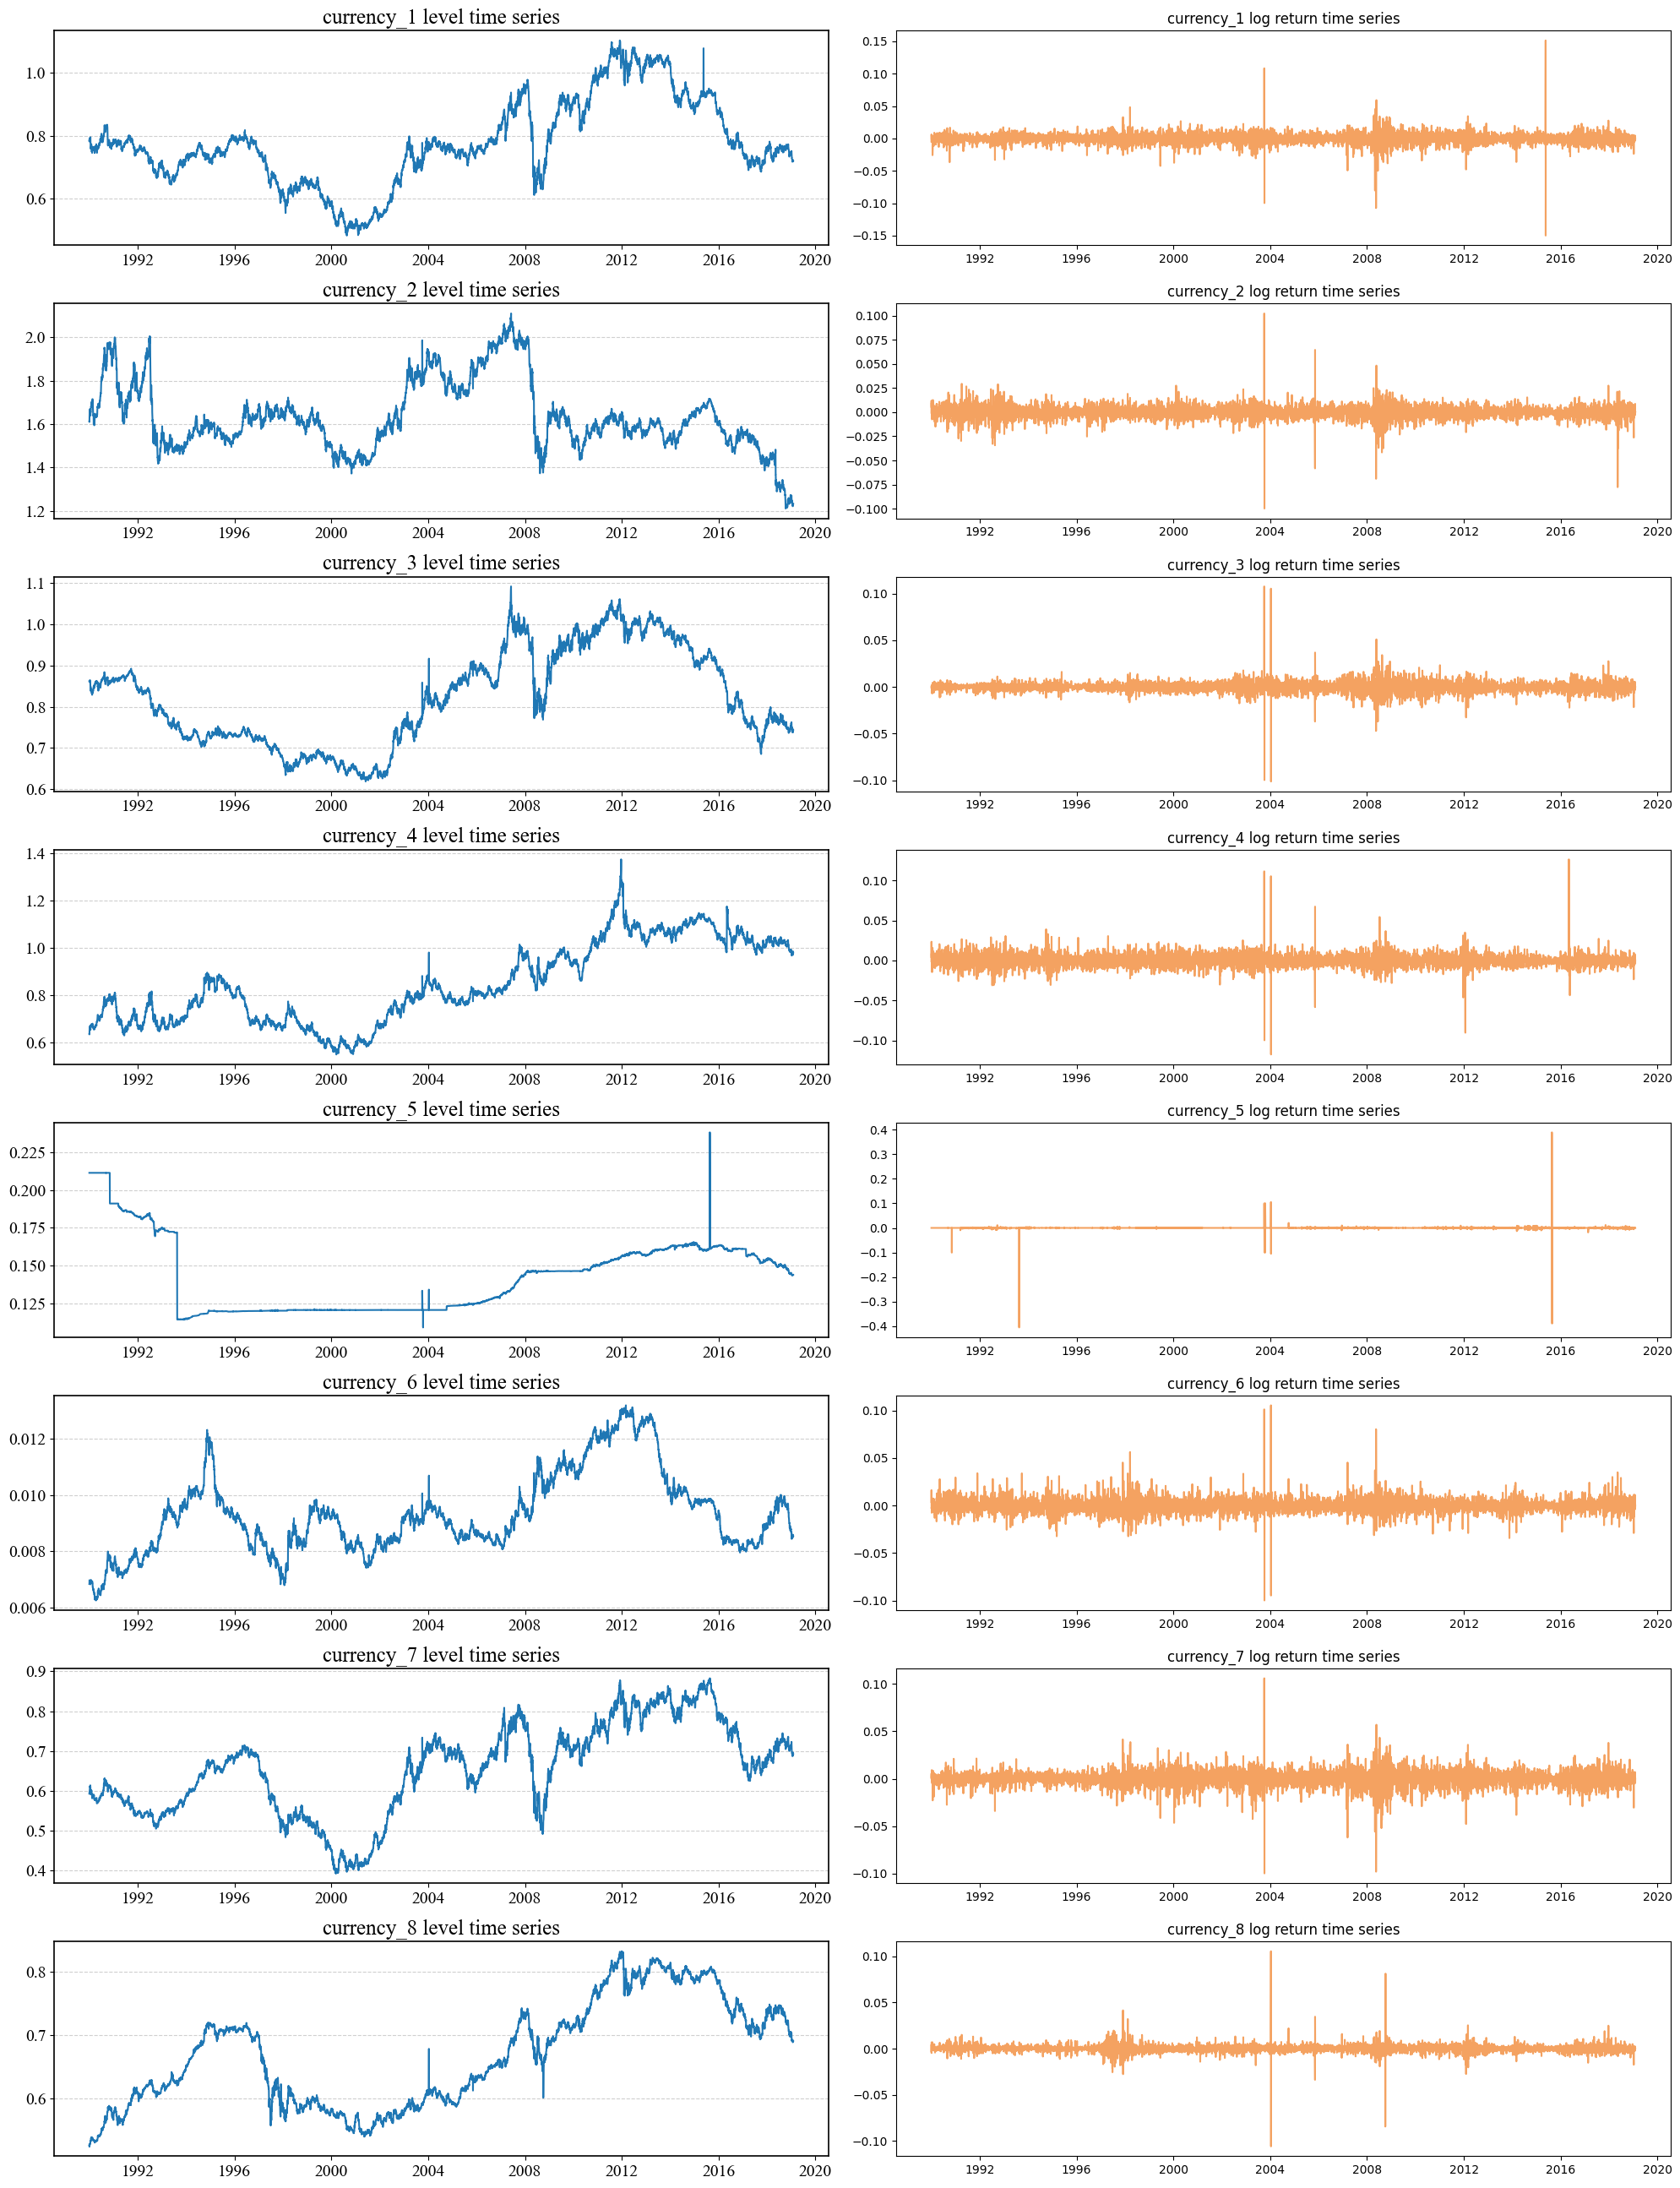

In [6]:
n_series = len(data.columns)
f, axs = plt.subplots(n_series, 2, figsize=(20, 26))
for i, tname in enumerate(data.columns):
    # Plot level time series
    axs[i][0].plot(level_data[tname])
    axs[i][0].set_title(f"{tname} level time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])
    
    # Plot log return time series
    axs[i][1].plot(data[tname], color="#F4A261")
    axs[i][1].set_title(f"{tname} log return time series")
    plot_style.apply_plot_style(axs[i][0])
    plot_style.apply_grid(axs[i][0])

### Convert to GluonTS Format

To use GluonTS models, we need to convert our pandas DataFrame into a **GluonTS-compatible dataset**.

We've already covered how to do this in the `GluonTS Tutorial`, and we've refactored the logic into a utility function called `split_train_test_datasets` for reuse across different notebooks.

In [7]:
from genai4t.forecasting.data import split_train_test_datasets

In [8]:
train_ds, test_ds = split_train_test_datasets(
    data,
    DATA_CONFIG['prediction_length'],
    DATA_CONFIG['split_date'],
    DATA_CONFIG['freq'])

number of windows: 803


## Model: LagLlama Zero Shot

Transformers have shown remarkable success in modeling long-range dependencies across various types of sequential data, such as text, audio, and video. Naturally, this raises the question: Can Transformers also be effectively applied to time series data?

As discussed in Chapter 5 of the book, time series—like text—are inherently sequential. One promising approach for adapting Transformers to time series problems is to convert continuous time series values into discrete tokens. This idea is explored in [Chronos: Learning the Language of Time Series](https://arxiv.org/abs/2403.07815) (Ansari et al., 2024).


An alternative to discretizing time series data is to use continuous values directly, allowing the model to take continuous inputs and produce continuous outputs. This approach requires adjustments both at the input level (to create “token embeddings”) and at the output level, since we're solving a regression problem rather than a classification task typical in language modeling. This is the approach taken in [Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting](https://arxiv.org/abs/2310.08278) (Rasul et al., 2024).



In Lag-Llama, the authors adapt the [LLaMA](https://arxiv.org/abs/2302.13971) model (Touvron et al., 2023)—a decoder-only Transformer architecture—to output continuous values by introducing a final layer that predicts the parameters of continuous probability distributions (specifically, a Student's t-distribution), rather than the categorical distributions used in typical classification settings.

The key modifications in Lag-Llama include:
1. A probabilistic continuous output layer
2. Incorporation of lagged and date-time features
3. Input normalization and outlier control

In this framework, the current and lagged values of the series, along with engineered date-time features, are concatenated into a single input vector. See the figure below (adapted from Figure 1 in Rasul et al., 2024) for an illustration of how these features are constructed.



![](./../../assets/figures/chapter05/paper-lagllama-figure-1.png)

In the figure below (adapted from Figure 2 in Rasul et al., 2024), you will see an illustration showing how the model input, comprising the time series value, date-time features, and summary statistics, is projected into the transformer's 'token embedding' space, creating a 'token representation' similar to NLP applications.

![](./../../assets/figures/chapter05/paper-lagllama-figure-2.png)

By enriching the current input with lagged and date-time features, the authors provide the Llama model with more contextual information to capture long-term and short-term dependencies. 

A few more details can be found in Chapter 5 of the book,  while more specific details are provided in the paper. [Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting](https://arxiv.org/abs/2310.08278).


#### Evaluation setup

In the following experiment, we explore the use of Lag-Llama on the Exchange Rate dataset. Since this dataset was not used to train the model (as stated in the pape), we will evaluate its **zero-shot** performance.

Similar to the experiments in the Chronos notebook, we will perform the evaluation on returns data, and readers are encouraged to explore alternative data settings.

### Using LagLlama

To experiment with the Lag-Llama model, we use an implementation based on the official [Lag-Llama GitHub repository]((https://github.com/time-series-foundation-models/lag-llama)). 

Since it is not available as a Python package, key components of the code have been copied into the `genai4t` package to simplify importing and usage. Full credit goes to the authors of the original project.

The authors provide a LagLlamaEstimator, which produces a PyTorchEstimator for forecasting new time series. 

In this notebook, we use it to forecast the ExchangeRate dataset without any additional training, which is known as zero-shot.

In [9]:
# Import main libraries
from genai4t.forecasting.predictors.lag_llama import LagLlamaEstimator
import torch
import os
from huggingface_hub import hf_hub_download

In [10]:
# Define the model configuration
MODEL_CONFIG = {
    # Path to store or load the pretrained Lag-Llama model weights.
    # The directory will be created if it doesn't exist.
    # This path is relative to the current working directory.
    "pretrained_dir": "./artifacts/pretrained_lagllama"
}

In [11]:
# Ensure the directory for storing the pretrained model exists
os.makedirs(MODEL_CONFIG['pretrained_dir'], exist_ok=True)

# Download the Lag-Llama model checkpoint from Hugging Face Hub
# The file will be saved to the specified local directory
model_path = hf_hub_download(
    repo_id="time-series-foundation-models/Lag-Llama",
    filename="lag-llama.ckpt",
    local_dir=MODEL_CONFIG['pretrained_dir']
)

# Confirm the download location
print(f"Model downloaded to: {model_path}")

lag-llama.ckpt:   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Model downloaded to: artifacts/pretrained_lagllama/lag-llama.ckpt


In [12]:
# Check if the current device is Apple's MPS
if device.type == 'mps':
    # Lag-Llama is not compatible with MPS, so we fall back to using the CPU
    print("LagLlama is not compatible with MPS device, falling back to CPU")
    device = torch.device('cpu')

LagLlama is not compatible with MPS device, falling back to CPU


In [13]:
# Uses GPU since in this Colab we use a GPU.
ckpt = torch.load(model_path, map_location=device) 
pretrained_estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    # Path to the pretrained model checkpoint
    ckpt_path=model_path,
    
    # Number of future time steps to predict
    prediction_length=DATA_CONFIG['prediction_length'],
    
    # Number of past time steps used as context for prediction
    # Lag-Llama was trained with context length of 32, but works with any length
    context_length=DATA_CONFIG['context_length'],

    # Model architecture parameters from pretrained checkpoint
    input_size=pretrained_estimator_args["input_size"],      # Input dimension size
    n_layer=pretrained_estimator_args["n_layer"],            # Number of transformer layers
    n_embd_per_head=pretrained_estimator_args["n_embd_per_head"],  # Embedding dim per attention head
    n_head=pretrained_estimator_args["n_head"],              # Number of attention heads
    scaling=pretrained_estimator_args["scaling"],            # Scaling factor for embeddings
    time_feat=pretrained_estimator_args["time_feat"],        # Whether to use time features
    
    # Disable rotary position embedding scaling
    rope_scaling=None,
    
    # Training parameters
    batch_size=1,                                 # Process one sample at a time
    num_parallel_samples=DATA_CONFIG['num_samples'],  # Number of parallel predictions
    device=device,                                # Device to run model on (CPU/GPU)
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

/var/folders/xh/gqg1nw952zdg25cwf006pxj80000gn/T/ipykernel_3347/3992077982.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=dev

## Inference and Evaluation

With the trained model wrapped in a `Predictor`, we can now:

1. Generate forecasts for the test set  
2. Visualize predictions vs. actual values  
3. Evaluate model performance using standard metrics

Let’s go through each of these steps.

In [14]:
# Generate probabilistic forecasts for the test input

forecasts: List[SampleForecast] = list(predictor.predict(
    test_ds.input,
    num_samples=DATA_CONFIG["num_samples"] # Number of forecast samples for uncertainty estimation
))

In [15]:
# Inspect the first forecast object
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='currency_1', samples=array([[ 0.00068397],
       [-0.00332218],
       [-0.00162246],
       [-0.00131077],
       [-0.00077621],
       [-0.00111738],
       [ 0.00230317],
       [-0.00061066],
       [-0.00185969],
       [ 0.00190356],
       [-0.00182663],
       [-0.00302092],
       [ 0.00182315],
       [-0.00308448],
       [ 0.00198142],
       [ 0.00061377],
       [-0.00080063],
       [ 0.01272303],
       [-0.00110389],
       [-0.00784916]], dtype=float32), start_date=Period('2016-01-04', 'B'))

In [16]:
# Convert test data to pandas DataFrames for visualization
tss: List[pd.DataFrame] = list(map(_to_dataframe, test_ds))

In [17]:
# Preview the tail of the first time series
tss[0].tail()

,0
2015-12-29,-0.002929
2015-12-30,0.007801
2015-12-31,-0.003295
2016-01-01,0.000132
2016-01-04,-0.002934


We’ll use the `compute_forecast_scores` function to evaluate the quality of our generated forecasts. It takes as input a list of `Forecast` and the ground truth time series `tss` 

In [18]:
from genai4t.evaluation.metrics import compute_forecast_scores
forecast_scores = compute_forecast_scores(tss, forecasts)
forecast_scores

Running evaluation: 6424it [00:00, 38797.17it/s]
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,MASE,MAPE,sMAPE,RMSE,wQuantileLoss[0.5],mean_wQuantileLoss
0,0.694935,2.551602,1.629215,0.005936,1.11495,0.806446


The `create_predictions_dataframe` function takes each forecast and its corresponding input time series and returns a DataFrame with the following columns:

- `item_id`: Identifier of the time series
- `forecast`: Median forecast value for each future step
- `horizon`: Time step ahead (e.g., 1-step, 2-steps,...)
- `target`: Actual observed values


The GluonTS predict method produces samples from the forecast distribution, we report the **median across samples** as the forecast point estimate. Be aware that if the model is not probabilistic, the predict method will produce the point estimate given by the model.

In [19]:
# Build a DataFrame with forecasts and ground truth
pd_predictions = create_predictions_dataframe(data, forecasts)
pd_predictions.tail(10)  # Show last 10 predictions

,item_id,forecast,horizon,target
timestamp,,,,
2019-01-17,currency_8,0.001934,1,0.000688
2019-01-18,currency_8,0.000208,1,0.000179
2019-01-21,currency_8,-0.001658,1,0.000000
2019-01-22,currency_8,-0.000838,1,-0.000224
2019-01-23,currency_8,-0.001101,1,-0.001179
2019-01-24,currency_8,0.000254,1,-0.002320
2019-01-25,currency_8,-0.000897,1,0.002499
2019-01-28,currency_8,0.000154,1,0.001637
2019-01-29,currency_8,0.000050,1,-0.000690


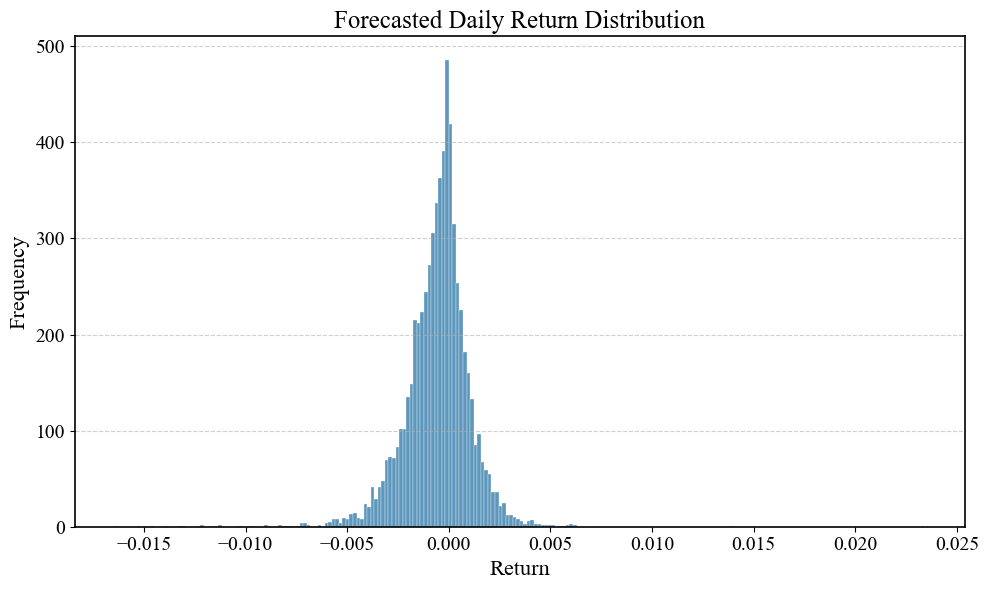

In [20]:
# Create styled figure and axis
fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))

# Plot histogram using Seaborn
sns.histplot(pd_predictions['forecast'], ax=ax, color="#2874A6", edgecolor="white")

ax.set_title("Forecasted Daily Return Distribution")
ax.set_xlabel("Return")
ax.set_ylabel("Frequency")

# Apply your custom style
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)

In [21]:
# Import custom evaluation metrics
from genai4t.evaluation.metrics import (
    compute_investment_scores,
    get_cumulative_returns)

In [22]:
scores = (
    pd_predictions
    .groupby(['item_id'])
    .apply(
        lambda df: pd.Series(compute_investment_scores(df["target"], df["forecast"])))
    .reset_index()
)

In [23]:
scores

,item_id,mean,std,sharpe,cum_return,spearman_corr
0,currency_1,-0.000444,0.006239,-1.130310,-0.300014,-0.036170
1,currency_2,-0.000271,0.005925,-0.727370,-0.195863,-0.104561
2,currency_3,-0.000102,0.004937,-0.327300,-0.078481,-0.040741
3,currency_4,0.000210,0.007270,0.459453,0.184063,-0.011597
4,currency_5,0.000005,0.001725,0.043089,0.003767,0.001801
5,currency_6,0.000024,0.005817,0.065907,0.019583,0.011247
6,currency_7,0.000076,0.006987,0.172388,0.062819,-0.003802
7,currency_8,-0.000005,0.003419,-0.024780,-0.004276,-0.025766


In [24]:
scores['cum_return'].sum()

-0.30840224027633667

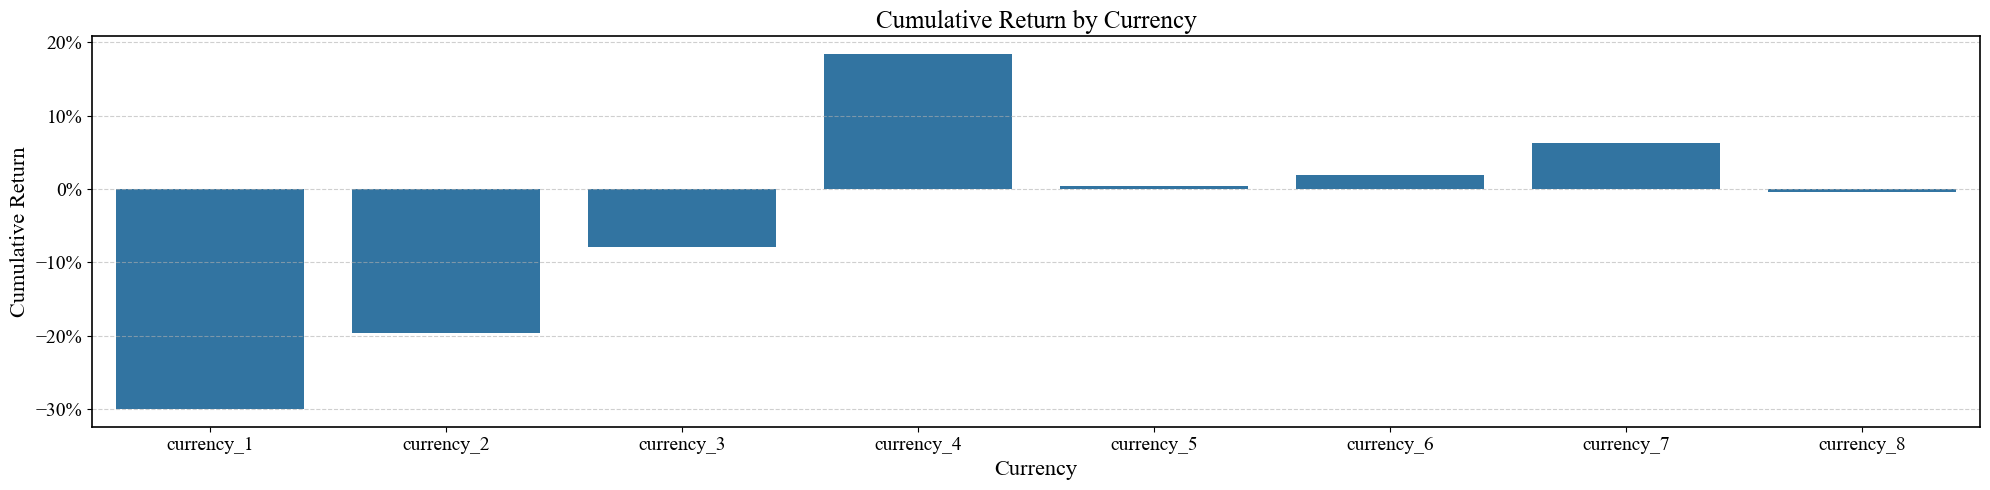

In [25]:
import matplotlib.ticker as mtick  
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='cum_return', data=scores)
ax.set_title("Cumulative Return by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Cumulative Return")

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

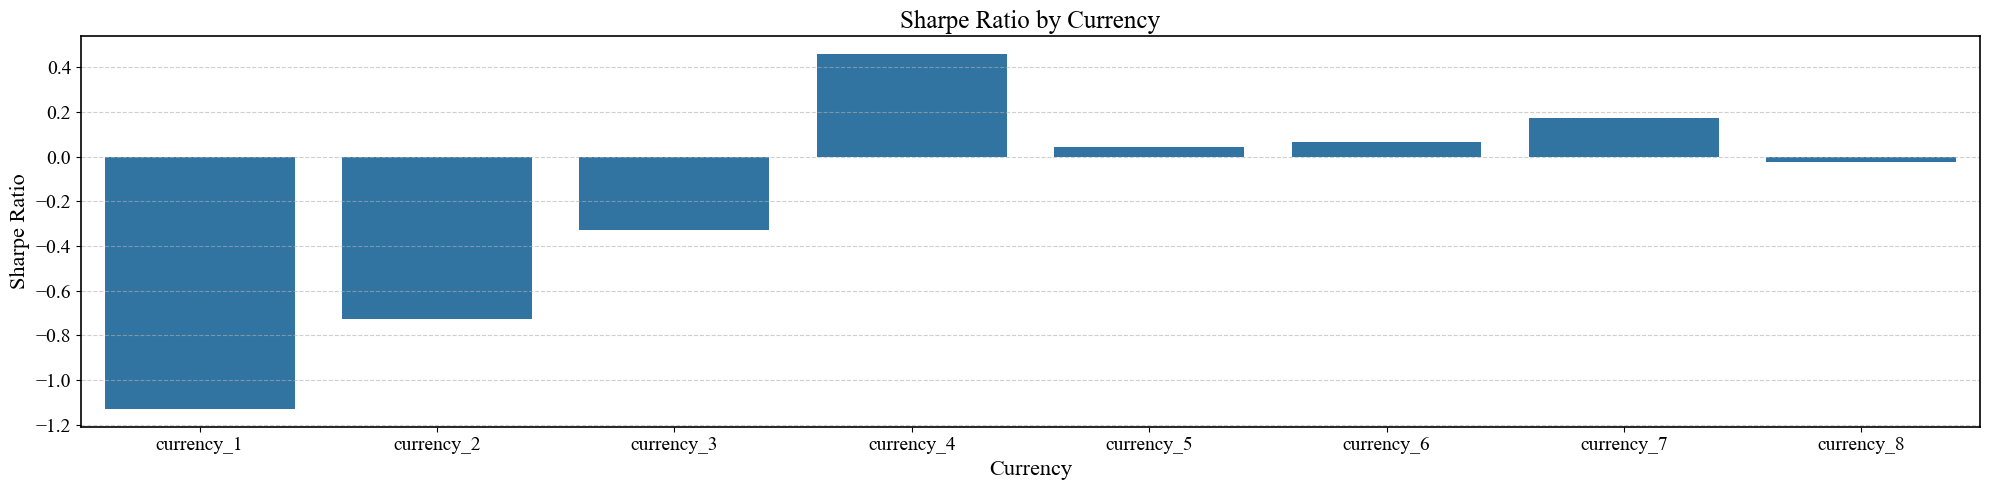

In [26]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='item_id', y='sharpe', data=scores)
ax.set_title("Sharpe Ratio by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Sharpe Ratio")

plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

In [27]:
pd_predictions['cum_return'] = (
    pd_predictions
    .groupby(['item_id'], group_keys=False)
    .apply(lambda df: get_cumulative_returns(df['target'], df['forecast']))
)

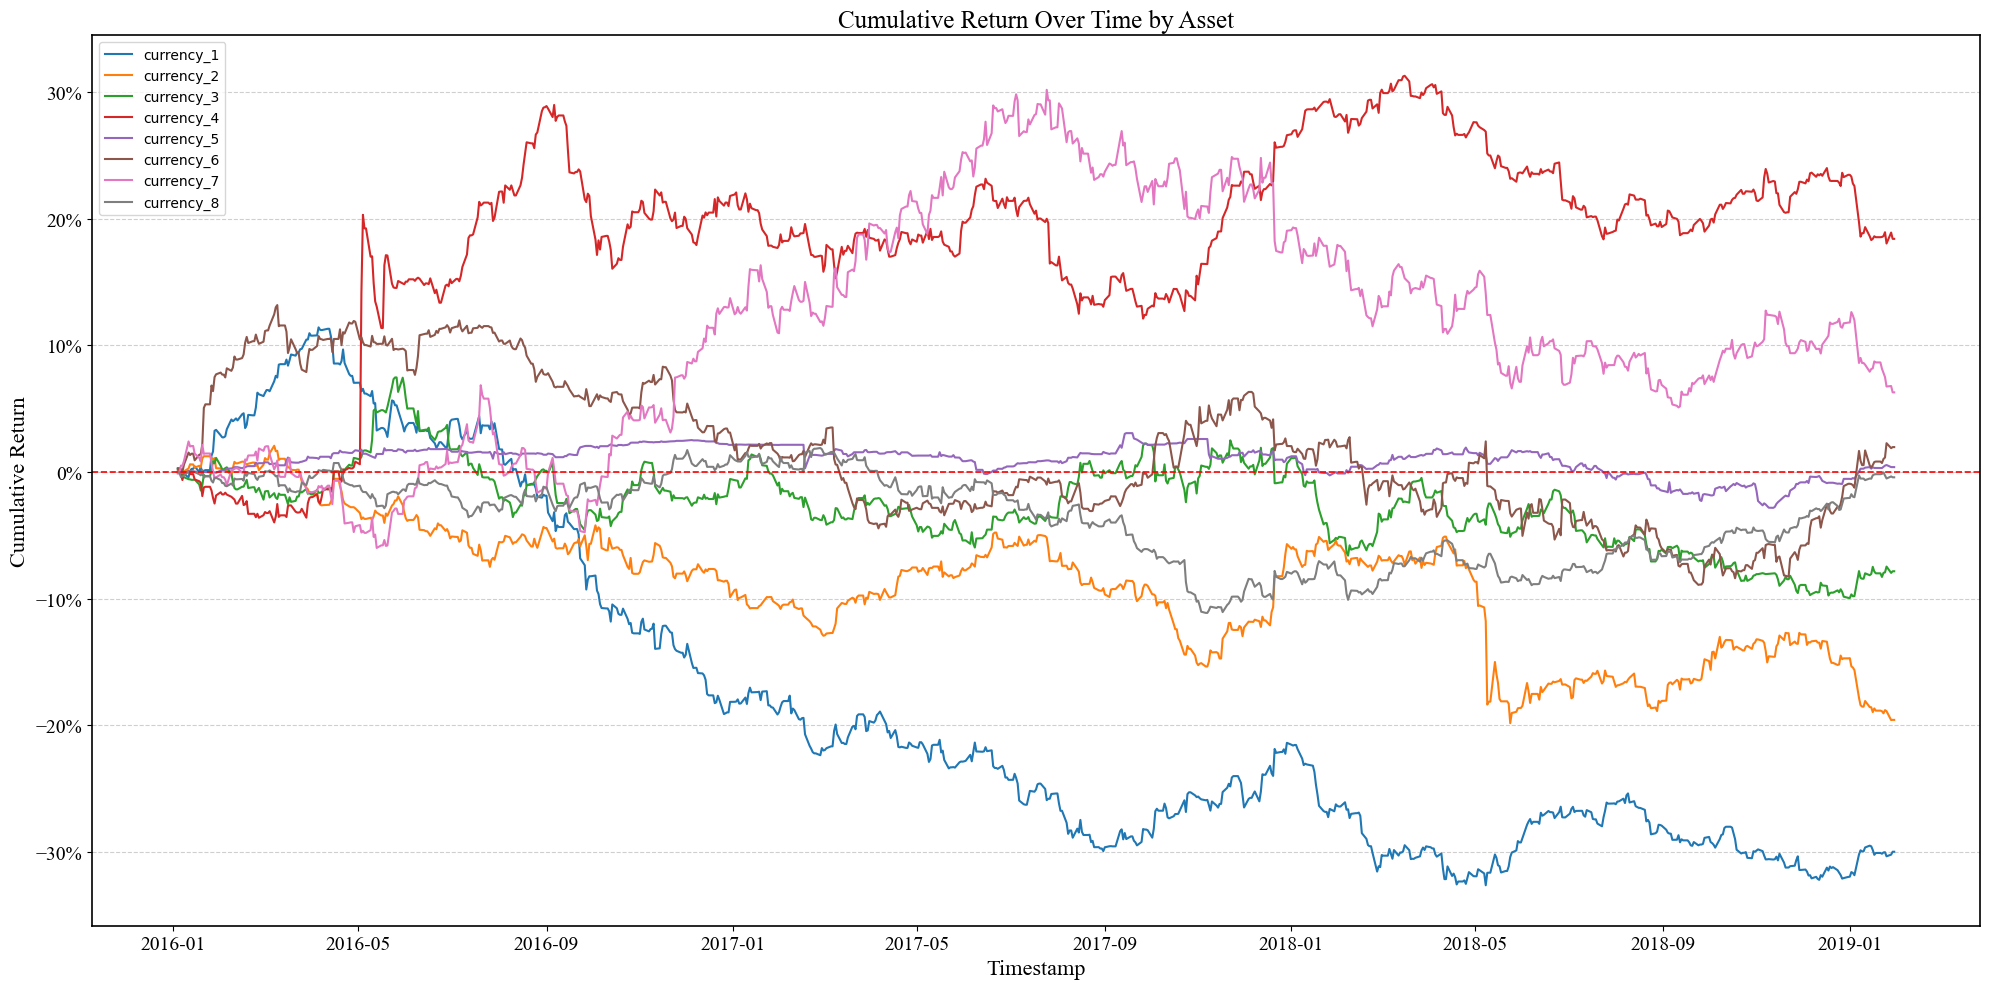

In [28]:
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    x="timestamp",
    y='cum_return',
    hue='item_id',
    data=pd_predictions.reset_index(),
    ax=ax)

# Horizontal reference line at 0%
ax.axhline(0., color='red', linestyle='--', linewidth=1.2)


# Format y-axis as percentages (assuming cum_return is in decimal form)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


# Title and labels
ax.set_title("Cumulative Return Over Time by Asset")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Cumulative Return")

# Apply custom styling
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="y")

# Handle legend (optional: move outside if too crowded)
ax.legend(loc="best")